PHASE 1: ASK



Business Objective: Conduct a comprehensive analysis of the sales performance of an online store, broken down by products, periods of time, and customers. From this analysis, the aim is to devise effective strategies to boost sales and improve future inventory management.

In [1]:
# Guiding questions:

# Which are the most sold products?

# Which products generate the most revenue?

# In which months, days, hours of day, are the most revenue generated? 

# Who are the most valuable customers? 

PHASE 2: PREPARE

In [2]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Creating the data frame
sales = pd.read_csv("C:/Users/adria/OneDrive/Documentos/Python/Sales_proyect/Online_Retail.csv", encoding='latin1')

In [4]:
# Checking data types
print(sales.dtypes)

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


In [5]:
# Getting details
print(sales.describe())
# Outliers were examined in Excel by appplying filters. 

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


PHASE 3: CLEANING

In [6]:
# In order to work with complete months, it is necessary to delimit the sales from 1st December 2010 to 30th November 2011

# First, conversion of column InvoiceDate from object type to datetime type
sales['InvoiceDate'] = pd.to_datetime(sales['InvoiceDate'], format='%d/%m/%Y %H:%M')

# Now, the filter can be applied
sales_clean = sales[sales['InvoiceDate'].between('2010-12-01', '2011-11-30')]

In [7]:
# I assume most of the NaN values in column CustomerID are uncompleted purchases, so them won´t be considered.
# The rest of NaN values seem to be missing products, them also won´t be considered for this project.

# Delete of NaN values in CustomerID column
sales_clean = sales_clean.dropna(subset=['CustomerID'])

In [8]:
# Count of NaN values before cleaning
nan_count = sales.isna().sum().sum()
print(f'The total amount of NaN values in CustomerID before cleaning is: {nan_count}')

# Count of NaN values after cleaning
nan_count_2 = sales_clean.isna().sum().sum()
print(f'The total amount of NaN values in CustomerID after cleaning is:{nan_count_2}')

The total amount of NaN values in CustomerID before cleaning is: 136534
The total amount of NaN values in CustomerID after cleaning is:0


In [9]:
# Creating new columns
sales_clean['Revenue'] = sales_clean['Quantity'] * sales['UnitPrice'] #Revenue column

sales_clean['InvoiceMonth'] = sales_clean['InvoiceDate'].dt.month     #InvoiceMonth column

sales_clean['InvoiceDay'] = sales_clean['InvoiceDate'].dt.day_name()   #InvoiceDay column

sales_clean['HourofDay'] = sales_clean['InvoiceDate'].dt.hour          #HourofDay column

In [10]:
# Rearrenging the order of columns
new_order = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'Revenue', 'InvoiceDate', 'InvoiceMonth', 'InvoiceDay', 'HourofDay', 'Country', 'CustomerID',]
sales_clean = sales_clean[new_order]

In [46]:
# Confirmying columns are OK
print(sales_clean.describe())

            Quantity      UnitPrice        Revenue  \
count  386973.000000  386973.000000  386973.000000   
mean       12.090707       3.492058      20.458891   
min    -74215.000000       0.000000  -77183.600000   
25%         2.000000       1.250000       4.250000   
50%         5.000000       1.950000      11.400000   
75%        12.000000       3.750000      19.500000   
max     74215.000000   38970.000000   77183.600000   
std       176.178161      70.996339     212.711078   

                         InvoiceDate   InvoiceMonth      HourofDay  \
count                         386973  386973.000000  386973.000000   
mean   2011-07-03 03:04:07.161740288       7.386156      12.725048   
min              2010-12-01 08:26:00       1.000000       6.000000   
25%              2011-03-31 16:41:00       5.000000      11.000000   
50%              2011-07-19 15:55:00       8.000000      13.000000   
75%              2011-10-11 13:13:00      10.000000      14.000000   
max              2011-1

PHASE  4 & 5: ANALYSIS AND SHARE

            Recency Frequency Monetary      
               mean      mean     mean count
RFM_Segment                                 
444             7.6     369.0   9296.4   411
111           258.5       7.5    126.3   383
344            28.0     236.2   4426.5   244
122           238.1      25.3    428.1   200
211            86.6       8.3    115.5   175
233            81.8      59.8   1014.0   175
222            85.0      26.1    442.3   167
433             9.1      63.4   1026.2   162
333            30.2      65.1   1055.9   148
244            77.0     181.2   2987.5   112


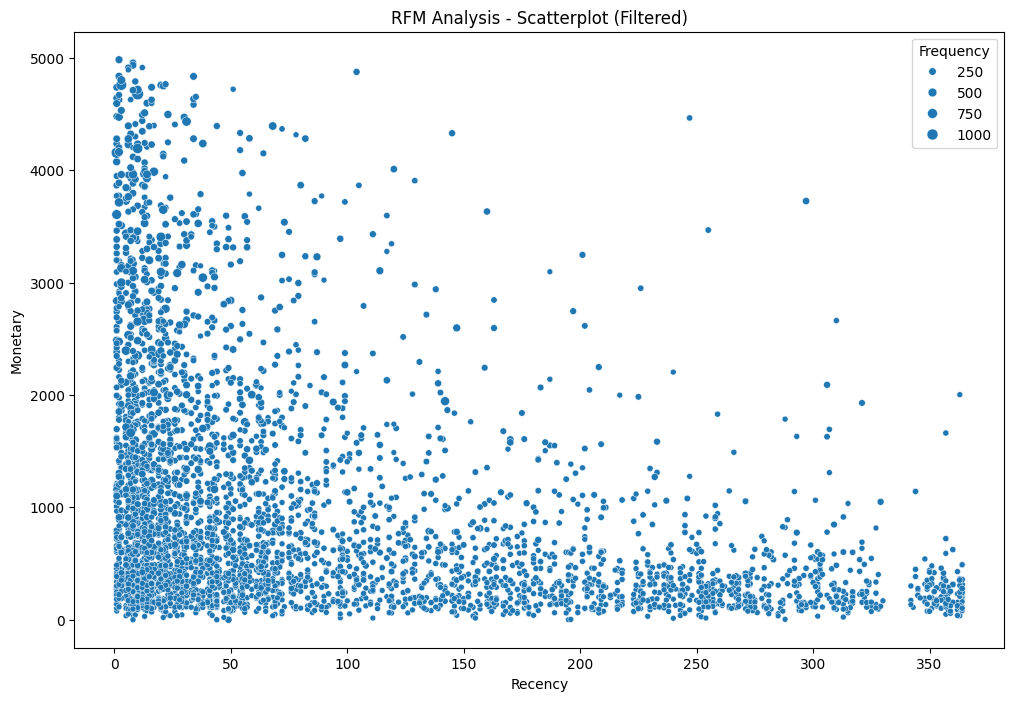

,Recency,Frequency,Monetary,RFM_Score
count,4326.000000,4326.000000,4326.000000,4326.000000
mean,91.273694,89.452843,1830.106006,7.514794
std,99.110803,219.969381,7939.918511,2.798867
min,1.000000,1.000000,-4287.630000,3.000000
25%,16.000000,17.000000,289.842500,5.000000
50%,48.000000,40.000000,633.315000,8.000000
75%,145.000000,98.000000,1546.152500,10.000000
max,364.000000,7512.000000,267761.000000,12.000000


In [27]:
# Analysis RFM (customer behaivor)

# First it´s neccesary to get the reference day (for recency)
snapshot_date = sales_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# Creating the metrics for analysis
rfm = sales_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Calculating Recency
    'InvoiceNo': 'count',  # Calculating Frecuency
    'Revenue': 'sum' # Calculating Monetary
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Clasification of RFM
# Dividing the data in 4 quartiles to assign the score
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=range(4, 0, -1))
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=range(1, 5))
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=range(1, 5))

# RFM Segments
# Concatenating scores as strings to create RFM segments
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Agrupation by segment
# Getting the mean for each metric by segment, and the number of customers in each segmnet
rfm_segments = rfm.groupby('RFM_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

# Selecting the top 10 segments based on the count of customers
top_10_segments = rfm_segments.sort_values(by=('Monetary', 'count'), ascending=False).head(10)
print(top_10_segments)

# Filtering Monetary values below a certain threshold to improve visualization
rfm_filtered = rfm[(rfm['Monetary'] > 0) & (rfm['Monetary'] < 5000)]

# Plot with data filtered
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Recency', y='Monetary', size='Frequency', data=rfm_filtered)
plt.title('RFM Analysis - Scatterplot (Filtered)')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

# Getting more info
rfm.describe()


Monthly revenue:
InvoiceMonth
11    1091886.890
10     974603.590
9      931440.372
5      648251.080
8      616368.000
6      608013.160
3      579964.610
7      574238.481
12     554604.020
1      475074.380
2      436546.150
4      426047.851
Name: Revenue, dtype: float64


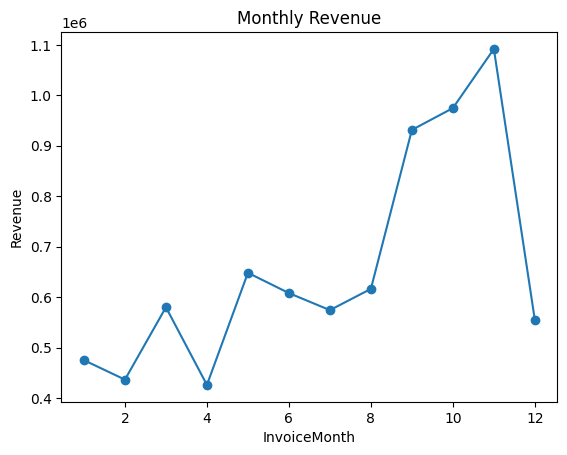

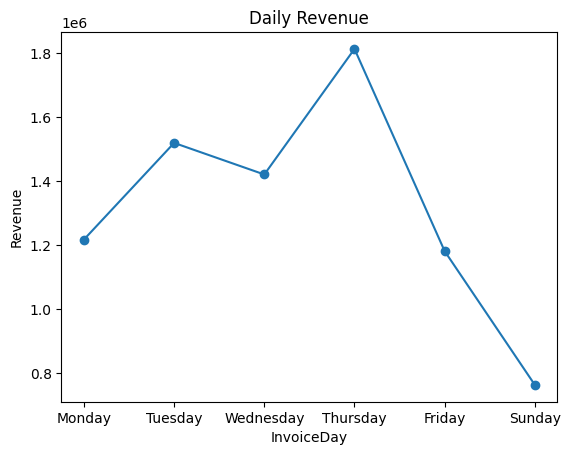

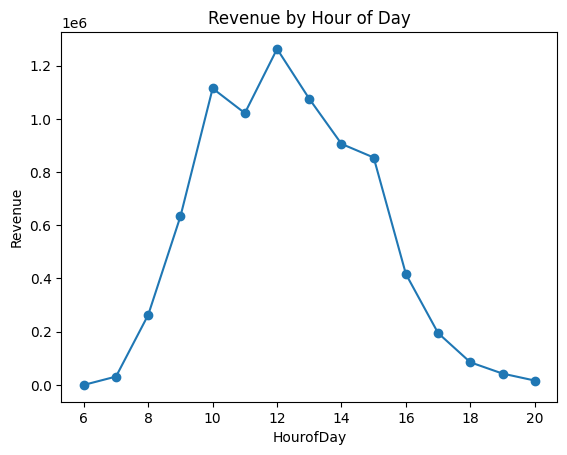

In [34]:
 # Analysis by time

# Monthly revenue 
monthly_revenue = sales_clean.groupby('InvoiceMonth')['Revenue'].sum().sort_values(ascending=False)
# print("Monthly revenue:")
# print(monthly_revenue)

# Plot
monthly_revenue = monthly_revenue.sort_index()
monthly_revenue.plot(kind='line', marker='o')
plt.title('Monthly Revenue')
plt.ylabel('Revenue')
plt.show()

 # Daily revenue 
daily_revenue = sales_clean.groupby('InvoiceDay')['Revenue'].sum().sort_values(ascending=False)
# print("Daily revenue:")
# print(daily_revenue)

# Plot
order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
daily_revenue = daily_revenue.loc[order_of_days]
daily_revenue.plot(kind='line', marker='o')
plt.title('Daily Revenue')
plt.ylabel('Revenue')
plt.show()

# Revenue by hour of day
byhour_revenue = sales_clean.groupby('HourofDay')['Revenue'].sum().sort_values(ascending=False)
# print("Revenue by hour of the day:")
# print(byhour_revenue)

# Plot
byhour_revenue = byhour_revenue.sort_index()
byhour_revenue.plot(kind='line', marker='o')
plt.title('Revenue by Hour of Day')
plt.ylabel('Revenue')
plt.show()

Most profitable products:
Description                         StockCode
REGENCY CAKESTAND 3 TIER            22423        128112.07
WHITE HANGING HEART T-LIGHT HOLDER  85123A        91018.51
JUMBO BAG RED RETROSPOT             85099B        80960.40
PARTY BUNTING                       47566         67172.73
POSTAGE                             POST          63475.74
ASSORTED COLOUR BIRD ORNAMENT       84879         54310.48
CHILLI LIGHTS                       79321         43780.14
RABBIT NIGHT LIGHT                  23084         43646.72
PICNIC BASKET WICKER 60 PIECES      22502         39619.50
PAPER CHAIN KIT 50'S CHRISTMAS      22086         36986.96
Name: Revenue, dtype: float64


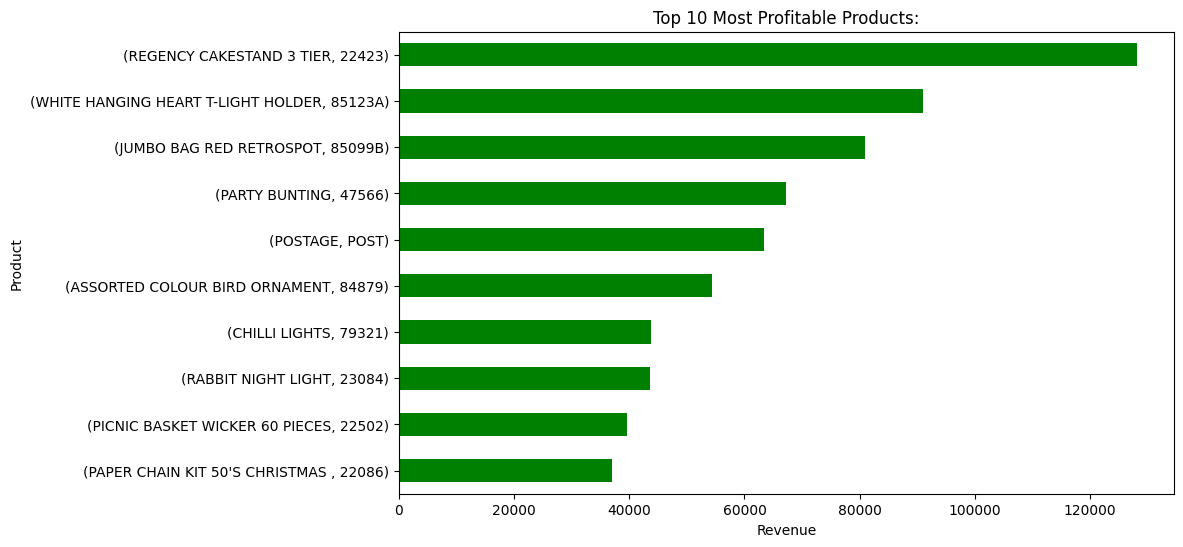

Top 10 Most sold products:
Description                         StockCode
WORLD WAR 2 GLIDERS ASSTD DESIGNS   84077        51612
JUMBO BAG RED RETROSPOT             85099B       43874
ASSORTED COLOUR BIRD ORNAMENT       84879        33928
WHITE HANGING HEART T-LIGHT HOLDER  85123A       33093
PACK OF 72 RETROSPOT CAKE CASES     21212        32902
MINI PAINT SET VINTAGE              22492        25481
POPCORN HOLDER                      22197        24803
PACK OF 12 LONDON TISSUES           22616        24660
PACK OF 60 PINK PAISLEY CAKE CASES  21977        23823
RABBIT NIGHT LIGHT                  23084        23081
Name: Quantity, dtype: int64


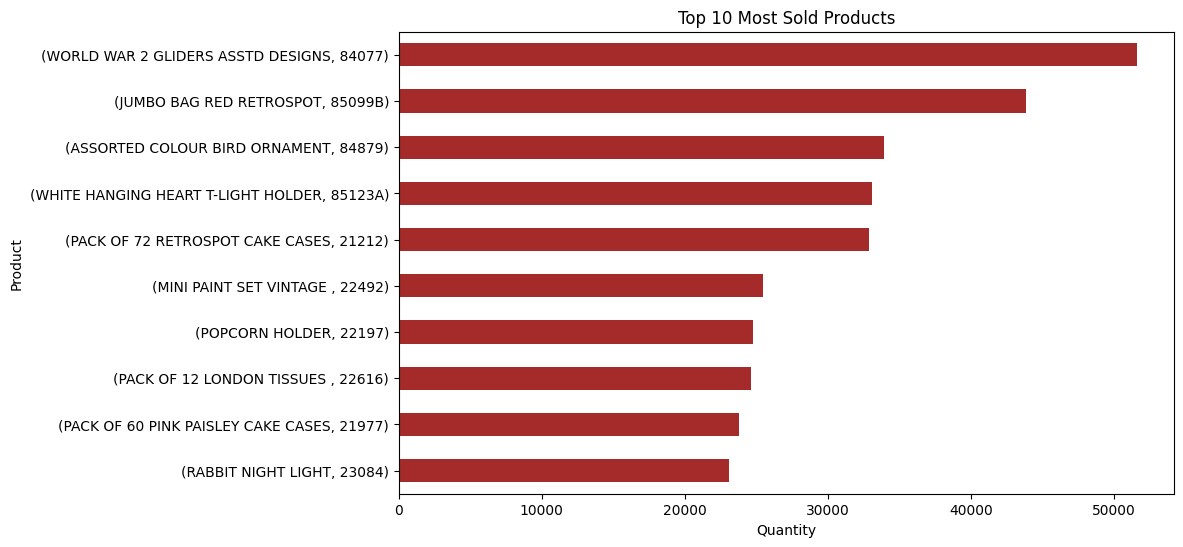

Products in both rankings:
MultiIndex([(           'JUMBO BAG RED RETROSPOT', '85099B'),
            (     'ASSORTED COLOUR BIRD ORNAMENT',  '84879'),
            ('WHITE HANGING HEART T-LIGHT HOLDER', '85123A'),
            (                'RABBIT NIGHT LIGHT',  '23084')],
           names=['Description', 'StockCode'])


In [48]:
# Analysis of products

# Most profitable products
most_profitable = sales_clean.groupby(['Description','StockCode'])['Revenue'].sum().sort_values(ascending=False).head(10)
print("Most profitable products:")
print(most_profitable)

# Plot
plt.figure(figsize=(10, 6))
most_profitable.plot(kind='barh', color='green')
plt.xlabel('Revenue')
plt.ylabel('Product')
plt.title('Top 10 Most Profitable Products:')  
plt.gca().invert_yaxis()
plt.show()

# Most sold products
most_sold = sales_clean.groupby(['Description','StockCode'])['Quantity'].sum().sort_values(ascending=False).head(10)
print("Top 10 Most sold products:") # Please ignore POSTAGE, it is not a product
print(most_sold)


# Plot
plt.figure(figsize=(10, 6))
most_sold.plot(kind='barh', color='brown')
plt.ylabel('Product')
plt.xlabel('Quantity')
plt.title('Top 10 Most Sold Products')
plt.gca().invert_yaxis()
plt.show()

# Products in both rankings
products_both_rankings = most_sold.index.intersection(most_profitable.index)
print("Products in both rankings:")
print(products_both_rankings)

In [14]:
# Key findings

# High-Value Customers are (RFM Segment = 444,), and At-Risk Customers are (RFM Segment = 111).

# The highest revenue-generating months are September, October, and November, while the most profitable days of the week are Tuesday and Thursday, and the peak hours for revenue generation are from 10:00 to 13:59.

# Products wich are both in most sold products and most profitable products are: JUMBO BAG RED RETROSPOT, ASSORTED COLOUR BIRD ORNAMENT,
# WHITE HANGING HEART T-LIGHT HOLDER and RABBIT NIGHT LIGHT.

PHASE 6: ACT

In [45]:
# The top three recomendations to boost sales and improve future inventory managment are:

# Loyalty Program and Retention Campaigns:

# High-Value Customers: invite them to join a loyalty program with exclusive benefits like special discounts,
# special prices, free merchandise. This will make them feel valued and encourage them to continue making purchases.
# At-Risk Customers: address these customers by sendig them limited-time promotions via email, to encourage them to buy more often.
# Additionally, send reminders about abandoned carts to motivate them to complete their purchases.

# Inventory Management:

# Valuable Products: The most valuable products are those that are both the most sold and the most profitable. 
# To ensure effective future inventory management, it is important to always have these products available in stock.

# Marketing and Customer Service:

# Marketing Budget: Allocate a larger marketing budget for the months of September, October, and November, 
# as these are the highest revenue-generating months.
# Customer Service: During peak hours, ensure that there are more employees available in the customer service department,
# to handle customer requests promptly. This will help avoid delays and keep customers satisfied.